### Load data first

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import time
import sys

sys.path.append(os.path.abspath(".."))   # Add root path to sys.path
os.chdir("..")  # Change working directory to root path

from src.preprocessing import read_image, windy_preprocessing_pipeline
from tqdm import tqdm
from datetime import datetime

sys.path


['/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python311.zip',
 '/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11',
 '/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload',
 '',
 '/Users/trantrunghcmut/Documents/hcmut/semester 251/Thunderstorm Nowcasting/Thunderstorm-Nowcasting-Geometry-Approach/.venv/lib/python3.11/site-packages',
 '/Users/trantrunghcmut/Documents/hcmut/semester 251/Thunderstorm Nowcasting/Thunderstorm-Nowcasting-Geometry-Approach']

Image shape: (505, 1220, 3)
--------------------


Processing images and detecting storms: 100%|██████████| 206/206 [01:42<00:00,  2.01it/s]

Number of frames: 206
--------------------
Sample DBZ map:


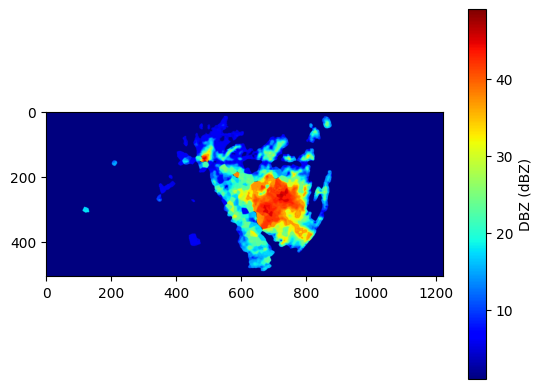

In [17]:
SOURCE_PATH = "data/images/philippines_13.269_123.832"
# SOURCE_PATH = "data/data_011125/vietnam"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
]

img_shape = read_image(img_paths[0]).shape       # get shape of the image
print(f"Image shape: {img_shape}")
print(f"-" * 20)

time_frames = []
dbz_maps = []       

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    time_frames.append(datetime.strptime(os.path.basename(path).split('/')[0][:-4], '%Y%m%d-%H%M%S'))       # Get file name without extension
    img = read_image(path)
    dbz_maps.append(windy_preprocessing_pipeline(img))

print(f"Number of frames: {len(dbz_maps)}")

print(f"-" * 20)

print("Sample DBZ map:")
plt.imshow(dbz_maps[0], cmap='jet')
plt.colorbar(label='DBZ (dBZ)')
plt.show()

## Load model

In [ ]:
from src.models import TitanPrecipitationModel
from src.identification import SimpleContourIdentifier

model = TitanPrecipitationModel(identifier=SimpleContourIdentifier())

storms_maps = []
total_storms = 0

pbar = tqdm(zip(dbz_maps, time_frames), total=len(dbz_maps), desc="Detecting storms")
for idx, (dbz_map, time_frame) in enumerate(pbar):
    storms_map = model.identify_storms(dbz_map, time_frame, map_id=f"time_{idx}", threshold=35, filter_area=50)
    total_storms += len(storms_map.storms)
    pbar.set_postfix({"Total storms detected": total_storms})

    storms_maps.append(storms_map)

Detecting storms: 100%|██████████| 120/120 [00:01<00:00, 76.90it/s, Total storms detected=719] 


## Benchmark model
Assume that storm do not change overtime, use previous map as the predicted map

In [28]:
from src.cores.base import StormsMap
from src.cores.metrics import pod_score, far_score, csi_score

class PredictionBenchmarkModel:
    def __init__(self):
        self.pods = []
        self.fars = []
        self.csis = []
        self.actual = []
        self.predicted = []

    def evaluate_predict(self, actual_storms_map: StormsMap, predicted_storms_map: StormsMap):
        self.actual.append(actual_storms_map)
        self.predicted.append(predicted_storms_map)
        self.pods.append(pod_score(actual_storms_map, predicted_storms_map))
        self.fars.append(far_score(actual_storms_map, predicted_storms_map))
        self.csis.append(csi_score(actual_storms_map, predicted_storms_map))

# Create benchmark model
benchmark_model = PredictionBenchmarkModel()
PREDICT_FORWARD_STEPS = 3                           # 1 hour ahead

for t in tqdm(range(PREDICT_FORWARD_STEPS, len(storms_maps)), desc="Evaluating benchmark model"):
    actual_storms_map = storms_maps[t]
    predicted_storms_map = storms_maps[t - PREDICT_FORWARD_STEPS]  # Assume storm do not change
    benchmark_model.evaluate_predict(actual_storms_map, predicted_storms_map)

print("Benchmark Model evaluation results:")
print(f"\tAverage POD: {np.mean(benchmark_model.pods):.4f}")
print(f"\tAverage FAR: {np.mean(benchmark_model.fars):.4f}")
print(f"\tAverage CSI: {np.mean(benchmark_model.csis):.4f}")

Evaluating benchmark model: 100%|██████████| 117/117 [00:00<00:00, 324.51it/s]

Benchmark Model evaluation results:
	Average POD: 0.4983
	Average FAR: 0.4721
	Average CSI: 0.3557


## Testing model tracking

In [29]:
model = TitanPrecipitationModel(identifier=SimpleContourIdentifier())  # max_velocity in pixels per hour

ours_model_evaluation = PredictionBenchmarkModel()
predicted_maps = []

# for map in storms_maps[:PREDICT_FORWARD_STEPS]:
model.processing_map(storms_maps[0])  # Initialize model with the first map

for curr_map, future_map in tqdm(zip(storms_maps[1:], storms_maps[PREDICT_FORWARD_STEPS:124]), desc="Predicting precipitation maps"):
    # Predict map using current data
    predicted_map = model.prediction(360 * PREDICT_FORWARD_STEPS)
    ours_model_evaluation.evaluate_predict(future_map, predicted_map)

    # Update new map into knowledge
    if model.storms_maps[-1].storms != []:
        model.processing_map(curr_map)  # Update model with the current map
    else:
        model.storms_maps.append(curr_map)

print("Our model evaluation:")
print(f"\tAverage POD: {np.mean(ours_model_evaluation.pods):.4f}")
print(f"\tAverage FAR: {np.mean(ours_model_evaluation.fars):.4f}")
print(f"\tAverage CSI: {np.mean(ours_model_evaluation.csis):.4f}")

Predicting precipitation maps: 117it [00:00, 277.37it/s]

Our model evaluation:
	Average POD: 0.4666
	Average FAR: 0.5077
	Average CSI: 0.3257


# Overall Analyzing on tracking process
In this tracking, I used both of the median duration and linearity error of tracking

### A. Meadian duration tracking

Median duration of tracking: 12.0 frames
Maximum duration of tracking: 117 frames
Mean duration of tracking: 21.55 frames


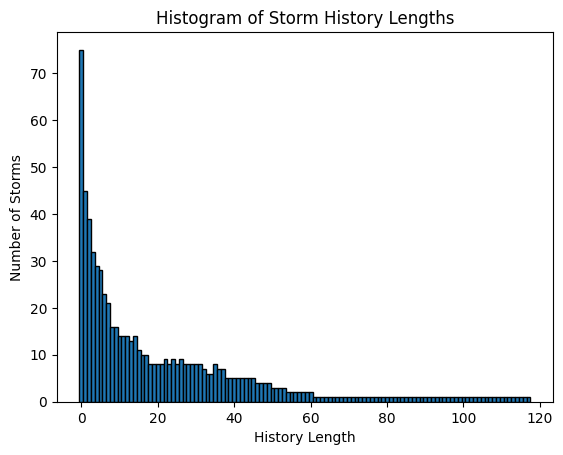

In [30]:
HISTORY_LENGTH_LST = []             # Retrieve history length of all storms

for storms_map in storms_maps:
    for storm in storms_map.storms:
        HISTORY_LENGTH_LST.append(len(storm.history_movements))   # Append history length of each storm

MEDIAN_DURATION = np.median(HISTORY_LENGTH_LST)

print(f"Median duration of tracking: {MEDIAN_DURATION} frames")
print(f"Maximum duration of tracking: {max(HISTORY_LENGTH_LST)} frames")
print(f"Mean duration of tracking: {np.mean(HISTORY_LENGTH_LST):.2f} frames")

plt.hist(HISTORY_LENGTH_LST, bins=range(0, max(HISTORY_LENGTH_LST) + 2), align='left', edgecolor='black')
plt.title("Histogram of Storm History Lengths")
plt.xlabel("History Length")
plt.ylabel("Number of Storms")
plt.show()

### B. Linearity error tracking
Use linearity to track the different between linear fitting of previous history against the actual matched movement

In [31]:
from sklearn.linear_model import LinearRegression
from functools import reduce
import matplotlib.pyplot as plt

def linear_error(movement_history: list[tuple[float, float]]) -> float:
    """
    Compute the linear fitting error distance of final point to the fitted line of previous points.
    """
    points = reduce(lambda points, movement: points + [(points[-1][0] + movement[0], points[-1][1] + movement[1])], movement_history, [(0, 0)])

    # Compute the linear fit parameters
    points = np.array(points)
    x = points[:-1, 0]
    y = points[:-1, 1]

    model = LinearRegression().fit(x.reshape(-1, 1), y)

    # Compute the distance from the final point to the fitted line
    final_point = points[-1]

    return abs(final_point[1] - (model.coef_[0] * final_point[0] + model.intercept_)) / np.sqrt(model.coef_[0]**2 + 1)

# Accumulate linear errors for all storms
LINEAR_ERRORS_LST = []

for storms_map in tqdm(storms_maps, desc="Computing linear fitting errors for storms"):
    for storm in storms_map.storms:
        # If not enough history, skip
        if len(storm.history_movements) <= MEDIAN_DURATION:
            continue

        # Fit linear model
        error_distance = linear_error(storm.history_movements[:-1]) ** 2      # Final one used for evaluate the movement prediction
        LINEAR_ERRORS_LST.append(error_distance)

print(f"RMSE of linear fitting errors: {np.sqrt(np.mean(LINEAR_ERRORS_LST)):.4f}. Total length: {len(LINEAR_ERRORS_LST)}")

Computing linear fitting errors for storms: 100%|██████████| 120/120 [00:00<00:00, 1930.10it/s]

RMSE of linear fitting errors: 13.3167. Total length: 353


Storm 0: Number of movement history records: 117
Storm 1: Number of movement history records: 49
Storm 2: Number of movement history records: 5


[]

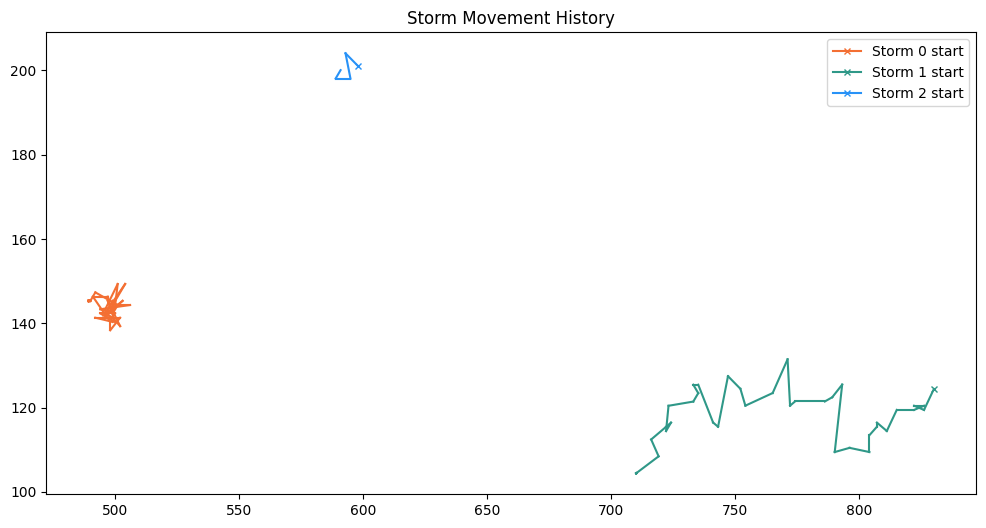

In [32]:
plt.figure(figsize=(12, 6))

for idx, storm in enumerate(storms_maps[-3].storms):
    print(f"Storm {idx}: Number of movement history records: {len(storm.history_movements)}")

    color = np.random.rand(3,)
    end_point = (storm.contour.centroid.x, storm.contour.centroid.y)

    for movement in storm.history_movements:
        start = end_point[0] - movement[0], end_point[1] - movement[1]
        plt.plot([start[0], end_point[0]], [start[1], end_point[1]], color=color)
        end_point = start
    
    plt.plot(end_point[0], end_point[1], marker='x', color=color, markersize=5, label=f'Storm {idx} start')

plt.legend()
plt.title("Storm Movement History")
plt.plot()
